In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm
from spectral import open_image

from test_iceland.paths import path_file_raw, path_file_black, path_file_white

x_roi = (1000, 1800)
y_roi = (200, 7800)

img = open_image(path_file_raw)
lams = img.bands.centers

height, width, channels = img.shape

C:\Users\Yannick Zander\Nextcloud2\Promotion\hyperspec\.venv\Lib\site-packages\spectral\io\envi.py:187: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


In [18]:
import numpy as np
bands = np.array(img.metadata['wavelength']).astype(float)

# define calibration for each sensor

In [19]:
import numpy as np

black = open_image(path_file_black).load()
white = open_image(path_file_white).load()

# calc average values for each sensor --> result is 2D array where rows correspond to different sensors and columns to bands
black_means = np.squeeze(black.mean(axis=0))
white_means = np.squeeze(white.mean(axis=0))

def calib_spec(spec: np.ndarray, j: int):
    white = white_means[j, :]
    black = black_means[j, :]
    
    # scale channel-wise
    scaled = (spec - black) / (white - black)
    return scaled


Text(0, 0.5, 'Intensity')

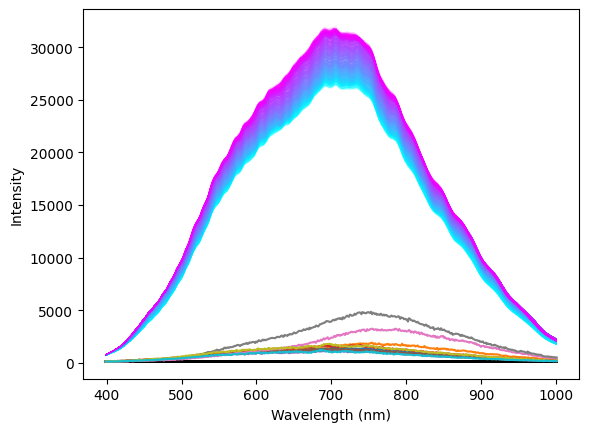

In [42]:
n_pixels_x = black.shape[1]
for i in range(n_pixels_x):
    plt.plot(bands, black_means[i, :], color='k')
    plt.plot(bands, white_means[i, :], color=(i / n_pixels_x, 1 - i / n_pixels_x, 1), linewidth=.05)
for j in range(10):
    x = np.arange(img.shape[1])
    y = np.arange(img.shape[0])
    plt.plot(bands, np.squeeze(img[np.random.choice(y), np.random.choice(x), :]))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')

In [43]:
black_means.shape

(2184, 476)

(0.0, 1.0)

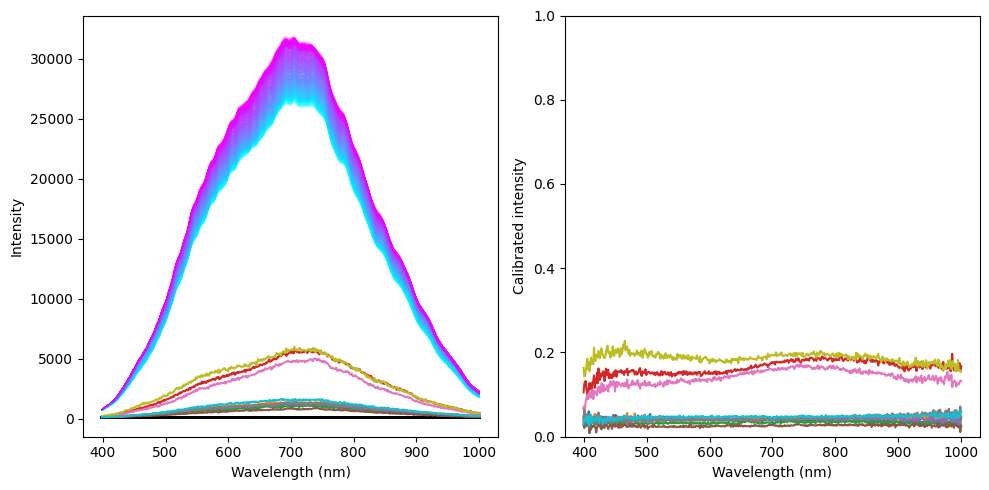

In [47]:
fig, axs = plt.subplots(ncols=2, layout='tight', figsize=(10, 5))

n_pixels_x = black.shape[1]
for i in range(n_pixels_x):
    axs[0].plot(bands, black_means[i, :], color='k')
    axs[0].plot(bands, white_means[i, :], color=(i / n_pixels_x, 1 - i / n_pixels_x, 1), linewidth=.05)

x = np.arange(img.shape[1])
y = np.arange(img.shape[0])
for _ in range(10):
    i = np.random.choice(y)
    j = np.random.choice(x)
    spec = np.squeeze(img[i, j, :])

    black_corr = black_means[j, :]
    white_corr = white_means[j, :]
    spec_scaled = calib_spec(spec, j)

    axs[0].plot(bands, spec)
    axs[1].plot(bands, spec_scaled)


axs[0].set_xlabel('Wavelength (nm)')
axs[1].set_xlabel('Wavelength (nm)')
axs[0].set_ylabel('Intensity')
axs[1].set_ylabel('Calibrated intensity')
axs[1].set_ylim([0, 1])

Text(0.5, 0, 'x index (white ref)')

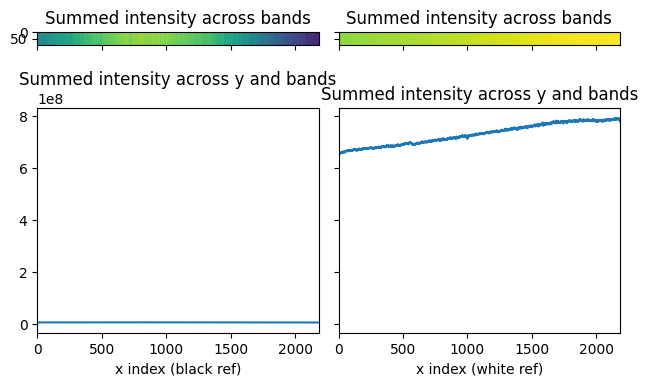

In [53]:
fig, axs = plt.subplots(ncols=2, nrows=2, layout="tight", sharex=True, sharey='row')
axs[0, 0].imshow(black.sum(axis=-1))
axs[0, 0].set_title('Summed intensity across bands')
# average over bands
axs[1, 0].plot(black.sum(axis=(0, 2)))
axs[1, 0].set_title('Summed intensity across y and bands')

axs[0, 1].imshow(white.sum(axis=-1))
axs[0, 1].set_title('Summed intensity across bands')
# average over bands
axs[1, 1].plot(white.sum(axis=(0, 2)))
axs[1, 1].set_title('Summed intensity across y and bands')

axs[1, 0].set_xlabel('x index (black ref)')
axs[1, 1].set_xlabel('x index (white ref)')

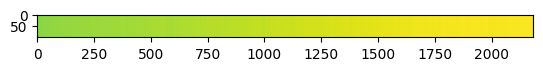

(np.float32(78.0), np.float32(32834.0))

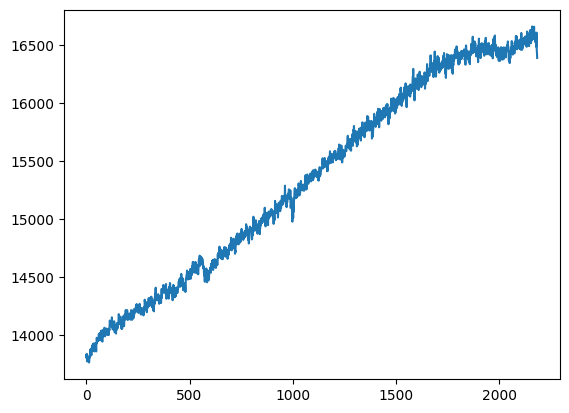

In [32]:
plt.imshow(white.sum(axis=-1))
plt.show()
# average over bands
plt.plot(white_means.mean(axis=-1))
white.min(), white.max()

In [3]:
roi = img[y_roi[0]:y_roi[1], x_roi[0]:x_roi[1], :] 

In [5]:
roi.shape

(7600, 800, 476)

In [6]:
calibrated = (roi - black_means[x_roi[0]:x_roi[1]]) / (white_means[x_roi[0]:x_roi[1]] - black_means[x_roi[0]:x_roi[1]])

In [7]:
calibrated.shape

(7600, 800, 476)

In [14]:
import h5py
from test_iceland.paths import path_file_hdf5

f = h5py.File(path_file_hdf5, 'w')

f.create_dataset(name='roi_calibrated', data=calibrated)

<HDF5 dataset "roi_calibrated": shape (7600, 800, 476), type "<f4">

# write to hdf5 file

In [ ]:
# from test_iceland.paths import path_file_hdf5
# 
# import h5py
# from tqdm import tqdm
# 
# f = h5py.File(path_file_hdf5, 'w')
# 
# I = np.arange(*y_roi)
# J = np.arange(*x_roi)
# for i in tqdm(I, total=I.shape[0]):
#     for j in J:
#         spec = img.read_pixel(i, j)
#         spec_calibrated = calib_spec(spec, j)

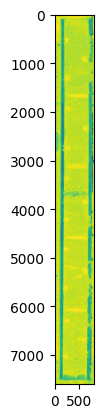

In [12]:
import matplotlib.pyplot as plt

plt.imshow(1 - calibrated[:, :, 50:100].mean(axis=2))

# compute MNF